# Introduction

The objective of this model is to detect, through the person's photo, whether or not he is wearing a mask.

# Imports

In [1]:
#import all libraries
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
#import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from keras import callbacks
from sklearn.metrics import accuracy_score
from os import listdir
from os.path import isfile, join
import visualkeras

# Load and Pre-processing Data

In [2]:
# Pipeline parameters
BATCH_SIZE = 32  # Number of images per batch
IMG_SIZE = (100, 100)  # Size of the resized images
PATH = 'Data/Face_Mask_Dataset/'  # Path to the dataset directory

In [3]:
# Train dataset
train_dir = os.path.join(PATH, 'Train')  # Path to the training dataset directory

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,  # Path to the directory containing the training images
    batch_size=BATCH_SIZE,  # Number of images per batch
    image_size=IMG_SIZE,  # Size of the resized images
    shuffle=True  # Shuffle the dataset for randomness
)

Found 10000 files belonging to 2 classes.


In [4]:
# Validation dataset
validation_dir = os.path.join(PATH, 'Validation')  # Path to the validation dataset directory

validation_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,  # Path to the directory containing the validation images
    batch_size=BATCH_SIZE,  # Number of images per batch
    image_size=IMG_SIZE,  # Size of the resized images
    shuffle=True  # Shuffle the dataset for randomness
)

Found 800 files belonging to 2 classes.


In [5]:
# Test dataset
test_dir = os.path.join(PATH, 'Test')  # Path to the test dataset directory

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,  # Path to the directory containing the test images
    batch_size=BATCH_SIZE,  # Number of images per batch
    image_size=IMG_SIZE,  # Size of the resized images
    shuffle=False  # Do not shuffle the dataset
)

Found 992 files belonging to 2 classes.


In [6]:
# Class names
class_names = train_ds.class_names  # Get the class names from the training dataset
print(class_names)  # Print the class names

['WithMask', 'WithoutMask']


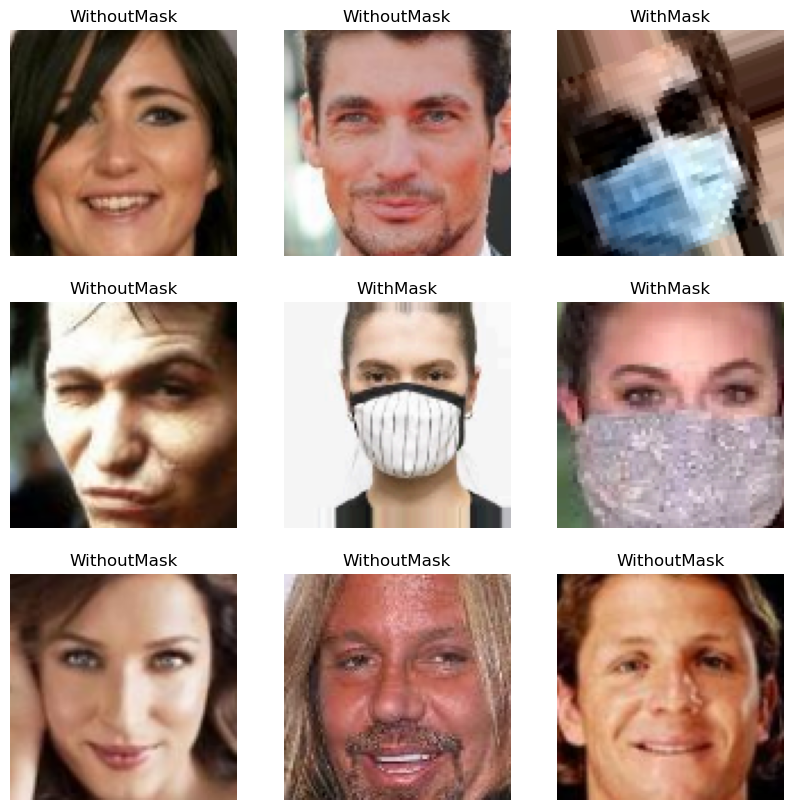

In [9]:
# data visualization
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
# Autotune buffer to avoid I/O block
AUTOTUNE = tf.data.AUTOTUNE  # Constant for autotuning buffer size

# Cache and prefetch the training dataset
train_ds = train_ds.cache()  # Cache the training dataset in memory for faster access
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)  # Prefetch the data for improved performance

# Cache and prefetch the validation dataset
validation_ds = validation_ds.cache()  # Cache the validation dataset in memory for faster access
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)  # Prefetch the data for improved performance

# Deep Learning

## Build and Compile Model

In [11]:
num_classes = 2  # Number of classes in the classification problem

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),  # Rescale input pixel values to the [0, 1] range
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),  # 32 filters, 3x3 kernel, ReLU activation
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Max pooling with 2x2 pool size (downsampling)
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),  # 64 filters, 3x3 kernel, ReLU activation
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Max pooling with 2x2 pool size (downsampling)
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),  # 128 filters, 3x3 kernel, ReLU activation
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Max pooling with 2x2 pool size (downsampling)
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),  # 256 filters, 3x3 kernel, ReLU activation
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Max pooling with 2x2 pool size (downsampling)
    tf.keras.layers.Flatten(),  # Flatten the feature map to a 1D vector
    tf.keras.layers.Dense(256, activation='relu'),  # Fully connected layer with 256 units and ReLU activation
    tf.keras.layers.Dense(num_classes, activation='sigmoid')  # Output layer with num_classes units and sigmoid activation
])

# Compile the model
model.compile(
    optimizer='adam',  # Adam optimizer
    loss=tf.losses.SparseCategoricalCrossentropy(),  # Sparse categorical cross-entropy loss
    metrics=['accuracy']  # Accuracy metric for evaluation
)

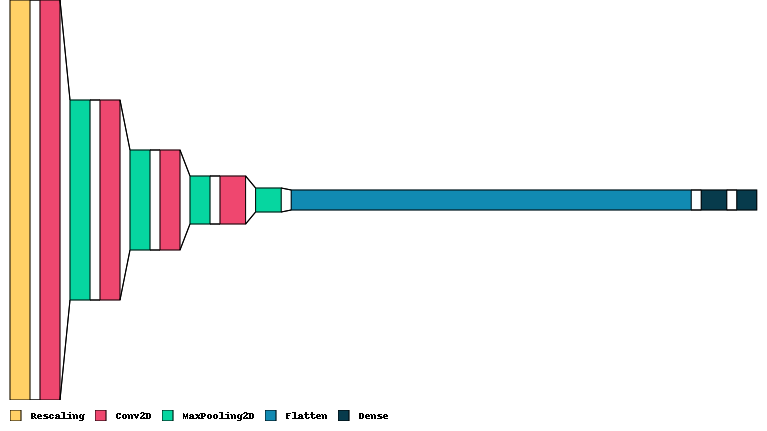

In [40]:
#visualizing the layers of a deep learning model
visualkeras.layered_view(model, legend=True,  draw_volume=False)


In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       7

## Fit

In [12]:
# Define the early stopping callback
earlystopping = callbacks.EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    mode="min",  # Minimize the monitored quantity
    patience=6,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the weights from the epoch with the best validation loss
    verbose=1  # Print information about the early stopping criteria
)

In [13]:
# Train the model
history = model.fit(
    train_ds,  # Training dataset
    validation_data=validation_ds,  # Validation dataset
    epochs=15,  # Number of epochs
    callbacks=[earlystopping]  # Early stopping callback
)

Epoch 1/15
313/313 [==============================] - 69s 216ms/step - loss: 0.1344 - accuracy: 0.9457 - val_loss: 0.0409 - val_accuracy: 0.9850
Epoch 2/15
313/313 [==============================] - 53s 169ms/step - loss: 0.0396 - accuracy: 0.9867 - val_loss: 0.0252 - val_accuracy: 0.9912
Epoch 3/15
313/313 [==============================] - 53s 170ms/step - loss: 0.0360 - accuracy: 0.9883 - val_loss: 0.0366 - val_accuracy: 0.9850
Epoch 4/15
313/313 [==============================] - 54s 171ms/step - loss: 0.0285 - accuracy: 0.9902 - val_loss: 0.0112 - val_accuracy: 0.9950
Epoch 5/15
313/313 [==============================] - 55s 174ms/step - loss: 0.0214 - accuracy: 0.9919 - val_loss: 0.0117 - val_accuracy: 0.9987
Epoch 6/15
313/313 [==============================] - 54s 173ms/step - loss: 0.0236 - accuracy: 0.9920 - val_loss: 0.0076 - val_accuracy: 0.9987
Epoch 7/15
313/313 [==============================] - 60s 192ms/step - loss: 0.0139 - accuracy: 0.9951 - val_loss: 0.0092 - val_ac

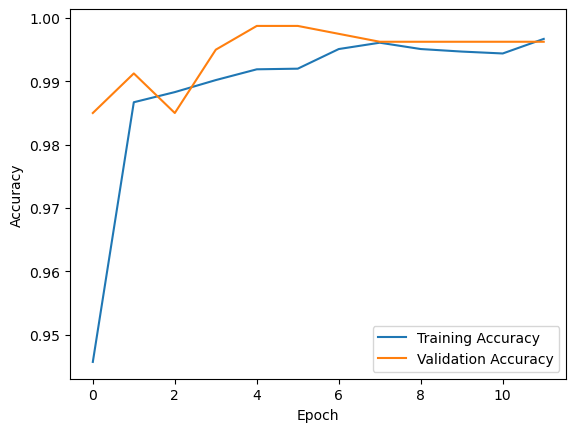

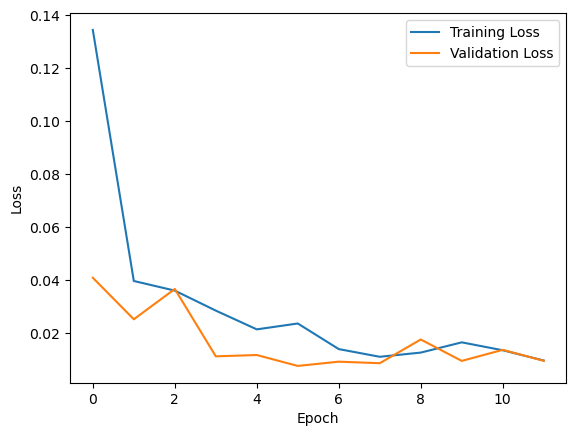

In [14]:
# Get the accuracy and loss values from the history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Save the trained model to a file
model.save('src/models/model2.h5')

In [16]:
import keras
from keras.models import load_model

from keras.preprocessing import image
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
# Load a saved model from a file
model2 = load_model("src/models/model2.h5")

In [18]:
#test 1

# Load the image and convert it to an array
image_path = "Data/1002.png"
i = Image.open(image_path).convert("RGB")
i = i.resize((100, 100))
i = np.array(i)

# Reshape the array to have dimensions (1, 100, 100, 3)
i = i.reshape(1, 100, 100, 3)

In [19]:
# Make predictions
predictions = model2.predict(i)

# Round the probabilities and convert them to integers
rounded_predictions = np.round(predictions).astype(int)

# Get the predicted class index
#predicted_class_index = rounded_predictions[0][0]
# Get the predicted class index based on the threshold of 0.5
predicted_class_index = 0 if rounded_predictions[0][0] >= 0.5 else 1

# Get the class label based on the predicted class index
class_labels = ['WithMask', 'WithoutMask']  # Replace with your actual class labels
predicted_class_label = class_labels[predicted_class_index]

print(predictions)
print(predicted_class_index)
print(predicted_class_label)

1/1 [==============================] - 0s 101ms/step
[[9.993197e-01 9.317296e-04]]
0
WithMask


In [20]:
#test 2

# Load the image and convert it to an array
image_path = "Data/1003.png"
i = Image.open(image_path).convert("RGB")
i = i.resize((100, 100))
i = np.array(i)

# Reshape the array to have dimensions (1, 100, 100, 3)
i = i.reshape(1, 100, 100, 3)

In [21]:
# Make predictions
predictions = model2.predict(i)

# Round the probabilities and convert them to integers
rounded_predictions = np.round(predictions).astype(int)

# Get the predicted class index
#predicted_class_index = rounded_predictions[0][0]
# Get the predicted class index based on the threshold of 0.5
predicted_class_index = 0 if rounded_predictions[0][0] >= 0.5 else 1

# Get the class label based on the predicted class index
class_labels = ['WithMask', 'WithoutMask']  # Replace with your actual class labels
predicted_class_label = class_labels[predicted_class_index]
print(predictions)
print(predicted_class_index)
print(predicted_class_label)

1/1 [==============================] - 0s 25ms/step
[[0.00230396 0.999561  ]]
1
WithoutMask


## Evaluate

### Test set prediction accuracy

In [22]:
e = model.evaluate(test_ds)

print(f'Test set accuracy: {"{0:.2f}".format(e[1]*100)}%')

31/31 [==============================] - 2s 77ms/step - loss: 0.0175 - accuracy: 0.9960
Test set accuracy: 99.60%


### Confusion Matrix

In [23]:
test_pred = model.predict(test_ds)
test_pred = np.argmax(test_pred,axis = 1)
test_labels = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 2s 60ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

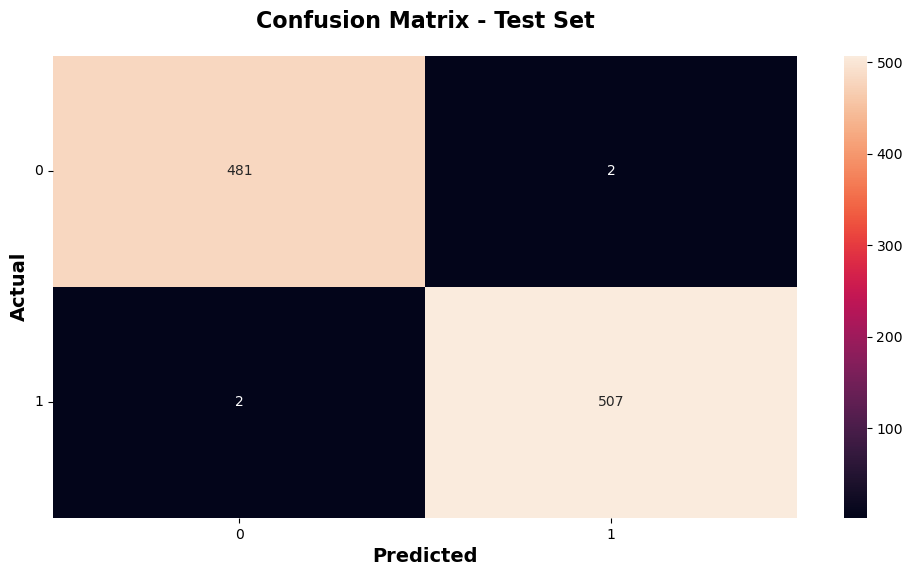

In [24]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels,
    test_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20)

# Results

The final accuracy on test set was **99.60%**. We can see on confusion matrix that, from the **992** images on test set, the model miss **2 with mask** and **2 without mask**.